In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid import ImageGrid

from tqdm.notebook import tqdm
import time
import random

plt.style.use("dark_background")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [2]:
BASE_PATH= "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

In [3]:
BASE_LEN = 89
END_LEN = 4
END_MASK_LEN = 9

IMG_SIZE = 512

# Get & Prepare Data

In [4]:
data = []

for dir_ in os.listdir(BASE_PATH):
    dir_path = os.path.join(BASE_PATH, dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"[INFO] This is not a dir --> {dir_path}")
        
df = pd.DataFrame(data, columns=["dir_name", "image_path"])


[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


In [5]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [6]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int(x[BASE_LEN: -END_LEN]))
masks = sorted(df_masks["image_path"].values, key=lambda x: int(x[BASE_LEN: -END_MASK_LEN]))

In [7]:
# sanity check
idx = random.randint(0, len(imgs)-1)
print(f"This image *{imgs[idx]}*\n Belongs to the mask *{masks[idx]}*")

This image */kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_45.tif*
 Belongs to the mask */kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_45_mask.tif*


In [8]:
# final dataframe
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})

dff.head()

,patient,image_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [9]:
def pos_neg_diagnosis(mask_path):
    val = np.max(cv2.imread(mask_path))
    if val > 0: return 1
    else: return 0

In [10]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

dff.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [11]:
dff.shape

(3929, 4)

In [12]:
print("Amount of patients: ", len(set(dff.patient)))
print("Amount of records: ", len(dff))

Amount of patients:  110
Amount of records:  3929


# Data Augmentation

In [13]:
!pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=ed54cea55b29111783389cd9bf1ce21c9acc9c53cdec4bbf0fcc621c1a274c36
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.model_selection import train_test_split

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class BrainMRIDataset:
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        
        augmented = self.transforms(image=image,
                                   mask=mask)
        
        image = augmented["image"]
        mask = augmented["mask"]
        
        return image, mask

In [17]:
PATCH_SIZE = 128

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(p=1.0),
    ToTensor(),
    
])

# Split Data and DataLoaders

In [18]:
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [19]:
train_dataset = BrainMRIDataset(train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=2, shuffle=True)

val_dataset = BrainMRIDataset(val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=2, shuffle=True)

test_dataset = BrainMRIDataset(test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=2, shuffle=True)

In [20]:
def show_aug(inputs, nrows=5, ncols=5, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

torch.Size([26, 3, 128, 128]) torch.Size([26, 1, 128, 128])


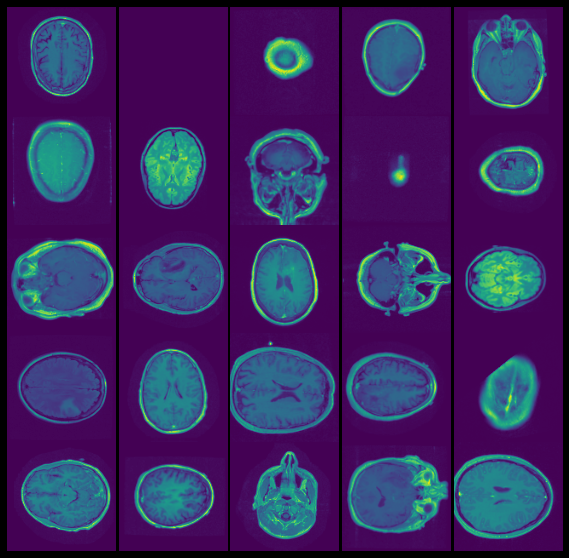

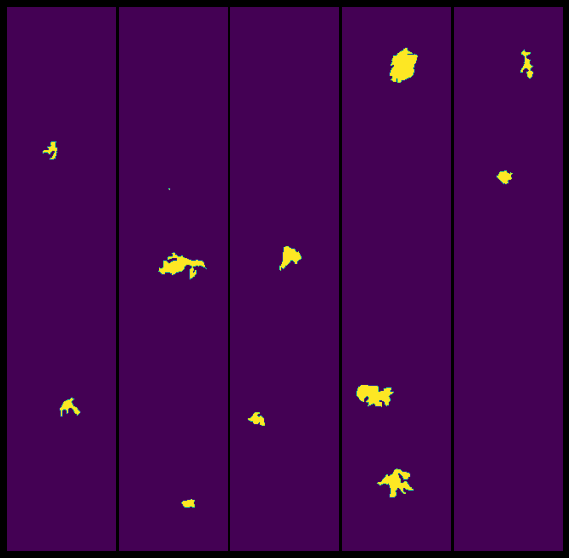

In [21]:
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, norm=False)

# Attention U-Net

## Model Blocks

In [22]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(ch_out, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [23]:
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

In [24]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x

## U-Net Model

In [25]:
class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=3, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

In [26]:
attention_unet = AttentionUNet(n_classes=1).to(device)

In [27]:
# check sanity
output = torch.randn(1,3,256,256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

## ResNet and DenseNet Models

In [28]:
import torchvision.models as models

class ResNetUNet(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super().__init__()
        self.base_model = models.resnet18(pretrained=pretrained)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = ConvBlock(64, 64)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = ConvBlock(64, 64)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = ConvBlock(128, 128)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = ConvBlock(256, 256)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = ConvBlock(512, 512)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = ConvBlock(256 + 512, 512)
        self.conv_up2 = ConvBlock(128 + 512, 256)
        self.conv_up1 = ConvBlock(64 + 256, 256)
        self.conv_up0 = ConvBlock(64 + 256, 128)

        self.conv_original_size0 = ConvBlock(3, 64)
        self.conv_original_size1 = ConvBlock(64, 64)
        self.conv_original_size2 = ConvBlock(64 + 128, 64)

        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x_original = self.conv_original_size0(x)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [29]:
class DenseNetUNet(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super().__init__()
        self.base_model = models.densenet121(pretrained=pretrained)
        self.base_layers = list(self.base_model.features.children())

        self.layer0 = nn.Sequential(*self.base_layers[:4])
        self.layer1 = nn.Sequential(*self.base_layers[4:6])
        self.layer2 = nn.Sequential(*self.base_layers[6:8])
        self.layer3 = nn.Sequential(*self.base_layers[8:10])
        self.layer4 = nn.Sequential(*self.base_layers[10:12])

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up4 = ConvBlock(1024, 512)
        self.conv_up3 = ConvBlock(512, 256)
        self.conv_up2 = ConvBlock(256, 128)
        self.conv_up1 = ConvBlock(128, 64)

        self.conv_original_size0 = ConvBlock(3, 64)
        self.conv_original_size1 = ConvBlock(64, 64)
        self.conv_original_size2 = ConvBlock(128, 64)  # Updated to take 128 channels as input

        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x_original = self.conv_original_size0(x)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        x = self.upsample(layer4)
        x = self.conv_up4(x)

        x = self.upsample(x)
        x = self.conv_up3(x)

        x = self.upsample(x)
        x = self.conv_up2(x)

        x = self.upsample(x)
        x = self.conv_up1(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)  # Concatenate upsampled features with original input
        x = self.conv_original_size2(x)  # Process the concatenated features

        out = self.conv_last(x)

        return out

In [30]:
resnet_unet = ResNetUNet(n_classes=1).to(device)
densenet_unet = DenseNetUNet(n_classes=1).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

# Segmentation Metric

In [31]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

# Segmentation Loss

In [32]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [33]:
# sanity check
DiceLoss()(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.1419)

# Training

In [34]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [35]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [36]:
opt = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)
opt_resnet = torch.optim.Adamax(resnet_unet.parameters(), lr=1e-3)
opt_densenet = torch.optim.Adamax(densenet_unet.parameters(), lr=1e-3)

In [37]:
%%time
num_ep = 50
# after 30 does not improve much

aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
rn_lh, rn_th, rn_vh = train_model("ResNet UNet", resnet_unet, train_dataloader, val_dataloader, DiceLoss(), opt_resnet, False, num_ep)
dn_lh, dn_th, dn_vh = train_model("DenseNet UNet", densenet_unet, train_dataloader, val_dataloader, DiceLoss(), opt_densenet, False, num_ep)

[INFO] Model is initializing... Attention UNet


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.9033076599240303 
Mean DICE on train: 0.3312900799153613 
Mean DICE on validation: 0.3558448728737901


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.7085423931479454 
Mean DICE on train: 0.5805091773407594 
Mean DICE on validation: 0.6591707378073186


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.436135637263457 
Mean DICE on train: 0.6609833830074696 
Mean DICE on validation: 0.7437383577922311


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.3343714346488317 
Mean DICE on train: 0.6913376419649988 
Mean DICE on validation: 0.6927452540698922


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.3147575413187345 
Mean DICE on train: 0.6998084781806898 
Mean DICE on validation: 0.6770250956253411


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.2903824518124262 
Mean DICE on train: 0.7190841904690006 
Mean DICE on validation: 0.6975416190502253


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.2984930743773778 
Mean DICE on train: 0.708344801564773 
Mean DICE on validation: 0.7180737501191675


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.263883164525032 
Mean DICE on train: 0.741586042849809 
Mean DICE on validation: 0.8039550539455517


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.2570015400648117 
Mean DICE on train: 0.7473079280042043 
Mean DICE on validation: 0.77098111661123


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.25962096055348716 
Mean DICE on train: 0.7438847295319112 
Mean DICE on validation: 0.7854847374262643


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.2607751364509265 
Mean DICE on train: 0.7422861957562618 
Mean DICE on validation: 0.7923875103452559


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.2455755705634753 
Mean DICE on train: 0.7573581626192861 
Mean DICE on validation: 0.7440067314541571


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.21781948506832122 
Mean DICE on train: 0.784183848818563 
Mean DICE on validation: 0.7840176340128971


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.2332916736602783 
Mean DICE on train: 0.7685609856719926 
Mean DICE on validation: 0.8365066839526151


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.23438702722390492 
Mean DICE on train: 0.7674899949852938 
Mean DICE on validation: 0.7931111962617899


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.22358319660027823 
Mean DICE on train: 0.7780614510552276 
Mean DICE on validation: 0.7951973891242822


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.21338896304368973 
Mean DICE on train: 0.788238545822305 
Mean DICE on validation: 0.8139753953392241


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.21496714055538177 
Mean DICE on train: 0.7862318655629107 
Mean DICE on validation: 0.8222788136123752


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.2145369345943133 
Mean DICE on train: 0.7865394792844682 
Mean DICE on validation: 0.858310100824002


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.21085905929406484 
Mean DICE on train: 0.790316323148701 
Mean DICE on validation: 0.7745617445579284


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.21167595585187277 
Mean DICE on train: 0.7895249656966918 
Mean DICE on validation: 0.805632791759542


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.19115448445081712 
Mean DICE on train: 0.8099531360697309 
Mean DICE on validation: 0.8498820192145264


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.19606092820564905 
Mean DICE on train: 0.8050174681433824 
Mean DICE on validation: 0.8744759857990058


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.1880469853679339 
Mean DICE on train: 0.8129567076216991 
Mean DICE on validation: 0.8471604743275761


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.18759885380665461 
Mean DICE on train: 0.8132649228468496 
Mean DICE on validation: 0.7614599856641157


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.19789531926314036 
Mean DICE on train: 0.802944087286649 
Mean DICE on validation: 0.841732102644059


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.1843129297097524 
Mean DICE on train: 0.8165646086307433 
Mean DICE on validation: 0.8707505014217622


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.1830597112576167 
Mean DICE on train: 0.817765860390781 
Mean DICE on validation: 0.8933698199728899


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.17296531200408935 
Mean DICE on train: 0.8278272652210213 
Mean DICE on validation: 0.8444935285051


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.18425509730974834 
Mean DICE on train: 0.8164611592749763 
Mean DICE on validation: 0.8693952672986931


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.19834679464499155 
Mean DICE on train: 0.802308296767953 
Mean DICE on validation: 0.8169346668960429


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.17157050569852192 
Mean DICE on train: 0.828968664573045 
Mean DICE on validation: 0.8637721228033932


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.16465177188316982 
Mean DICE on train: 0.8361999645088726 
Mean DICE on validation: 0.8585008698960519


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.1643303578098615 
Mean DICE on train: 0.8363870301046273 
Mean DICE on validation: 0.8604474460157127


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.15627151827017466 
Mean DICE on train: 0.8443197189022219 
Mean DICE on validation: 0.9015875584163751


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.16366117199261984 
Mean DICE on train: 0.8369218743020416 
Mean DICE on validation: 0.8152593187568979


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.16532814651727676 
Mean DICE on train: 0.8353326495228757 
Mean DICE on validation: 0.8328069368134777


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.1684249942501386 
Mean DICE on train: 0.8321687379963042 
Mean DICE on validation: 0.8263485556283431


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.16118696033954621 
Mean DICE on train: 0.8393108360579332 
Mean DICE on validation: 0.8543392576489669


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.15507192810376486 
Mean DICE on train: 0.8453837927508169 
Mean DICE on validation: 0.8930083174087058


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.16654888739188511 
Mean DICE on train: 0.8339096593535558 
Mean DICE on validation: 0.8449197478225692


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.1538326938947042 
Mean DICE on train: 0.8466757408787239 
Mean DICE on validation: 0.8827847194875318


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.1509857028722763 
Mean DICE on train: 0.8495122561241841 
Mean DICE on validation: 0.8330718824906377


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.15080830057462055 
Mean DICE on train: 0.8496746899487266 
Mean DICE on validation: 0.8865083945883412


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.16205001721779505 
Mean DICE on train: 0.8385027684212605 
Mean DICE on validation: 0.8862620567353413


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.1605027491847674 
Mean DICE on train: 0.8399510833875901 
Mean DICE on validation: 0.8846293025875546


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.15565620809793473 
Mean DICE on train: 0.8446921220718243 
Mean DICE on validation: 0.9084169474247676


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.1509088103969892 
Mean DICE on train: 0.8495589610129107 
Mean DICE on validation: 0.8329149696899999


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.1569627394278844 
Mean DICE on train: 0.8434648205430924 
Mean DICE on validation: 0.9031862636947755


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.1512492557366689 
Mean DICE on train: 0.8490516051022162 
Mean DICE on validation: 0.893969110791492
[INFO] Model is initializing... ResNet UNet


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.9210844000180562 
Mean DICE on train: 0.3511749973088262 
Mean DICE on validation: 0.4366023431780253


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.793929107983907 
Mean DICE on train: 0.6019951283651633 
Mean DICE on validation: 0.635320187350655


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.2636319746573766 
Mean DICE on train: 0.8083437077492637 
Mean DICE on validation: 0.7873341760644236


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.19589175681273144 
Mean DICE on train: 0.8350769786037726 
Mean DICE on validation: 0.8350944524836462


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.16795578549305598 
Mean DICE on train: 0.8489536368524455 
Mean DICE on validation: 0.8928393904151692


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.16310459474722544 
Mean DICE on train: 0.848786027918815 
Mean DICE on validation: 0.8458555028319051


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.14953350722789766 
Mean DICE on train: 0.8584355416825312 
Mean DICE on validation: 0.9198620926690432


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.13832210153341293 
Mean DICE on train: 0.8672737390173502 
Mean DICE on validation: 0.8579332526402124


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.1334378331899643 
Mean DICE on train: 0.871540718077745 
Mean DICE on validation: 0.9202944708768123


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.13782666623592377 
Mean DICE on train: 0.8665024135490745 
Mean DICE on validation: 0.8610410770415197


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.13276421229044597 
Mean DICE on train: 0.8703961975250338 
Mean DICE on validation: 0.8798822180716027


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.12914498299360275 
Mean DICE on train: 0.8737539098381556 
Mean DICE on validation: 0.9102916568715842


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.12364516158898671 
Mean DICE on train: 0.8783547664626271 
Mean DICE on validation: 0.9204444382941435


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.11735772391160329 
Mean DICE on train: 0.8844155783379805 
Mean DICE on validation: 0.9258456818416245


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.11881888061761856 
Mean DICE on train: 0.8829078898030235 
Mean DICE on validation: 0.9172639811866287


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.12523809522390367 
Mean DICE on train: 0.8763906867131659 
Mean DICE on validation: 0.9203362804738114


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.11632551401853561 
Mean DICE on train: 0.8849319233193721 
Mean DICE on validation: 0.9392428359239952


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.11675407439470291 
Mean DICE on train: 0.8843619175224056 
Mean DICE on validation: 0.8855556426358511


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.12049271762371064 
Mean DICE on train: 0.8805936534658552 
Mean DICE on validation: 0.9049687650713494


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.10865700840950013 
Mean DICE on train: 0.8922798867080994 
Mean DICE on validation: 0.9338112540271474


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.11145149568716685 
Mean DICE on train: 0.8893970430582172 
Mean DICE on validation: 0.8823670668878497


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.1116070106625557 
Mean DICE on train: 0.8893955812715109 
Mean DICE on validation: 0.9248338724067946


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.10930245121320088 
Mean DICE on train: 0.8915840096418984 
Mean DICE on validation: 0.9383734618068973


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.10889125416676203 
Mean DICE on train: 0.8918376248426834 
Mean DICE on validation: 0.9323180909075962


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.10801054487625758 
Mean DICE on train: 0.8926807141308571 
Mean DICE on validation: 0.9486945278485013


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.10549037257830302 
Mean DICE on train: 0.89515720214337 
Mean DICE on validation: 0.9311028345771849


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.10886839479207992 
Mean DICE on train: 0.8920398911242401 
Mean DICE on validation: 0.928622121288963


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.10265235553185145 
Mean DICE on train: 0.8978710304317523 
Mean DICE on validation: 0.9494662422769882


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.10631975630919138 
Mean DICE on train: 0.8941870825751058 
Mean DICE on validation: 0.9454473270846196


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.10242187182108561 
Mean DICE on train: 0.8980771645337815 
Mean DICE on validation: 0.9463303995367788


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.10160914013783137 
Mean DICE on train: 0.8988364611512334 
Mean DICE on validation: 0.8894768716248174


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.10221189260482788 
Mean DICE on train: 0.8982097276236298 
Mean DICE on validation: 0.942360986881464


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.10567747900883356 
Mean DICE on train: 0.8948794399368527 
Mean DICE on validation: 0.9298780770727337


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.1063155859708786 
Mean DICE on train: 0.8941384554664374 
Mean DICE on validation: 0.8733534103348987


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.10888116558392842 
Mean DICE on train: 0.8916252533603927 
Mean DICE on validation: 0.8884655971646056


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.10460636566082636 
Mean DICE on train: 0.8959645724342206 
Mean DICE on validation: 0.9391127790920476


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.10332213093837102 
Mean DICE on train: 0.8972293230093881 
Mean DICE on validation: 0.9296579542038556


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.09446661074956259 
Mean DICE on train: 0.9059207978169892 
Mean DICE on validation: 0.9418649791719819


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.09713718096415201 
Mean DICE on train: 0.9040569804651508 
Mean DICE on validation: 0.9512875731012307


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.09466396967569987 
Mean DICE on train: 0.905890438454127 
Mean DICE on validation: 0.956741348733034


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.09440587113300959 
Mean DICE on train: 0.9060674310382806 
Mean DICE on validation: 0.9534329578681557


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.09700796653827032 
Mean DICE on train: 0.903412167940846 
Mean DICE on validation: 0.9374414014231467


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.09391589015722275 
Mean DICE on train: 0.9065100760055369 
Mean DICE on validation: 0.9470274928988096


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.09419297377268473 
Mean DICE on train: 0.906245083065696 
Mean DICE on validation: 0.9429552932601035


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.09399347802003225 
Mean DICE on train: 0.9063225380033871 
Mean DICE on validation: 0.9600151813240381


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.09502662618954977 
Mean DICE on train: 0.9054319254048392 
Mean DICE on validation: 0.9526320383462495


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.09433842847744624 
Mean DICE on train: 0.9060021829728874 
Mean DICE on validation: 0.8963038024681355


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.09388445516427359 
Mean DICE on train: 0.9064586293304068 
Mean DICE on validation: 0.8874505112279649
[INFO] Model is initializing... DenseNet UNet


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.9122516537706057 
Mean DICE on train: 0.2664831610077301 
Mean DICE on validation: 0.5379528619337637


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.7298705746730169 
Mean DICE on train: 0.5716691231727274 
Mean DICE on validation: 0.6856052605328347


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.398942224184672 
Mean DICE on train: 0.7181624026577969 
Mean DICE on validation: 0.8204210832349251


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.30443849017222724 
Mean DICE on train: 0.7322143400667827 
Mean DICE on validation: 0.7268551106267498


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.23510740399360658 
Mean DICE on train: 0.7841644912265016 
Mean DICE on validation: 0.8043291508784723


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.22847527464230855 
Mean DICE on train: 0.7835686487807643 
Mean DICE on validation: 0.8419380089743124


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.21818817208210628 
Mean DICE on train: 0.7911408075131366 
Mean DICE on validation: 0.7850171487915708


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.18987274020910264 
Mean DICE on train: 0.8166506096870194 
Mean DICE on validation: 0.7779452838109344


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.1828974112868309 
Mean DICE on train: 0.8224729183914604 
Mean DICE on validation: 0.8390331865510245


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.18852424522240957 
Mean DICE on train: 0.816810275801621 
Mean DICE on validation: 0.8283016076990555


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.17486170381307603 
Mean DICE on train: 0.829060137258036 
Mean DICE on validation: 0.8916054264337029


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.16533155540625255 
Mean DICE on train: 0.837826522765927 
Mean DICE on validation: 0.8400922022828389


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.1643022835254669 
Mean DICE on train: 0.8386581486699594 
Mean DICE on validation: 0.8958897388389414


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.16497868498166401 
Mean DICE on train: 0.8375236214521511 
Mean DICE on validation: 0.8012556155356377


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.15841745684544245 
Mean DICE on train: 0.8446521116242889 
Mean DICE on validation: 0.8757624607734719


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.14413150598605473 
Mean DICE on train: 0.858082093708625 
Mean DICE on validation: 0.903275760436776


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.1391436517238617 
Mean DICE on train: 0.8629328452807111 
Mean DICE on validation: 0.8474774316399781


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.1488293429215749 
Mean DICE on train: 0.8531692055700837 
Mean DICE on validation: 0.9037412323026764


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.14918867498636246 
Mean DICE on train: 0.852815428302547 
Mean DICE on validation: 0.8389885697922159


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.14428489257891972 
Mean DICE on train: 0.8574362847076301 
Mean DICE on validation: 0.923327675585205


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.14162013630072276 
Mean DICE on train: 0.8602303172814324 
Mean DICE on validation: 0.9046173111021791


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.1375937283039093 
Mean DICE on train: 0.8641750377589752 
Mean DICE on validation: 0.9213507067306564


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.13227966328461965 
Mean DICE on train: 0.8693473178664781 
Mean DICE on validation: 0.9301684586323918


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.12924830665191014 
Mean DICE on train: 0.8721161447130373 
Mean DICE on validation: 0.8520205434928739


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.12291544526815415 
Mean DICE on train: 0.8786436898742992 
Mean DICE on validation: 0.912994739894722


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.12473296274741491 
Mean DICE on train: 0.8766076036581066 
Mean DICE on validation: 0.9354168987885687


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.11771561453739803 
Mean DICE on train: 0.8836153510627895 
Mean DICE on validation: 0.9321026083140471


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.12677334944407145 
Mean DICE on train: 0.8747219007104228 
Mean DICE on validation: 0.914251399827289


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.12151675174633662 
Mean DICE on train: 0.8795169840481445 
Mean DICE on validation: 0.8760581661723225


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.1313722754518191 
Mean DICE on train: 0.8698179873463171 
Mean DICE on validation: 0.9309310073720017


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.11849757879972458 
Mean DICE on train: 0.883000587360029 
Mean DICE on validation: 0.944861127226147


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.11554846813281378 
Mean DICE on train: 0.8855885159508838 
Mean DICE on validation: 0.9324750249715051


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.11399874488512675 
Mean DICE on train: 0.8871553462277418 
Mean DICE on validation: 0.905302909523613


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.11670467754205067 
Mean DICE on train: 0.8844323232231763 
Mean DICE on validation: 0.8664603602870996


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.11617248008648555 
Mean DICE on train: 0.8848151484714092 
Mean DICE on validation: 0.887377353470312


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.11288808882236481 
Mean DICE on train: 0.8880252321759176 
Mean DICE on validation: 0.9371830272932056


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.11290142883857092 
Mean DICE on train: 0.8879189109898273 
Mean DICE on validation: 0.9263728217488425


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.1135315328836441 
Mean DICE on train: 0.8872798515221407 
Mean DICE on validation: 0.865204271813685


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.11291885226964951 
Mean DICE on train: 0.887996630905367 
Mean DICE on validation: 0.9293382156412882


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.11085831224918366 
Mean DICE on train: 0.8899545119810365 
Mean DICE on validation: 0.9318728573942958


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.11154426783323287 
Mean DICE on train: 0.8893606433789526 
Mean DICE on validation: 0.8766980063849403


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.10433365454276403 
Mean DICE on train: 0.8963814453781462 
Mean DICE on validation: 0.9355677435458055


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.10513074696063995 
Mean DICE on train: 0.8955743449495538 
Mean DICE on validation: 0.9352898798166877


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.11335218499104181 
Mean DICE on train: 0.8874287998756093 
Mean DICE on validation: 0.9380924441559501


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.10431025971968969 
Mean DICE on train: 0.8964780201901471 
Mean DICE on validation: 0.947694986890679


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.10827598323424657 
Mean DICE on train: 0.8923872683602903 
Mean DICE on validation: 0.9353324913710909


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.10567876895268759 
Mean DICE on train: 0.8949350964140037 
Mean DICE on validation: 0.944233965665395


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.10461193124453226 
Mean DICE on train: 0.8959875396604683 
Mean DICE on validation: 0.8743545233000052


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.10870756308237711 
Mean DICE on train: 0.8918476063436955 
Mean DICE on validation: 0.8775017992298555


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.10517603158950806 
Mean DICE on train: 0.8954449534637433 
Mean DICE on validation: 0.9439820146425166
CPU times: user 2h 6min 19s, sys: 47min 26s, total: 2h 53min 45s
Wall time: 2h 54min 47s


In [38]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()

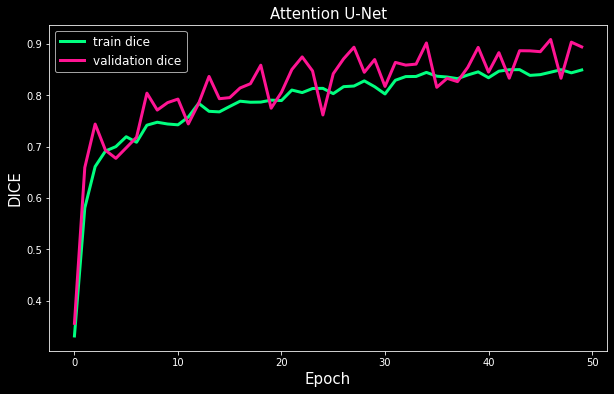

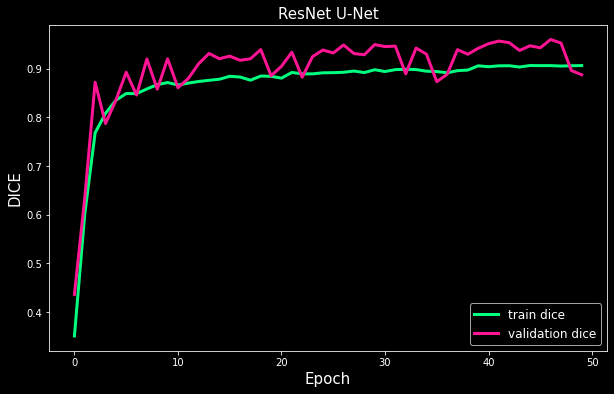

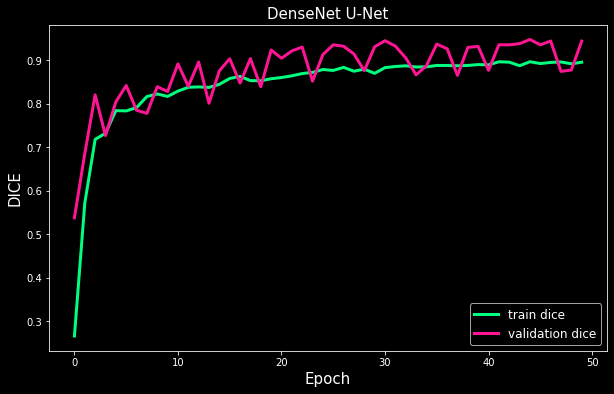

In [39]:
plot_model_history("Attention U-Net", aun_th, aun_vh, num_ep)
plot_model_history("ResNet U-Net", rn_th, rn_vh, num_ep)
plot_model_history("DenseNet U-Net", dn_th, dn_vh, num_ep)

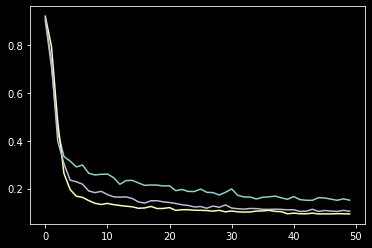

In [40]:
plt.plot(range(num_ep), aun_lh)
plt.plot(range(num_ep), rn_lh)
plt.plot(range(num_ep), dn_lh)


In [41]:
test_iou = compute_iou(attention_unet, test_dataloader)
test_iou_aun = compute_iou(densenet_unet, test_dataloader)
test_iou_rn = compute_iou(resnet_unet, test_dataloader)
print(f"""Performance comparison:
Attention U-Net: Mean IoU - {np.around(test_iou, 2)*100}%
ResNet U-Net: Mean IoU - {np.around(test_iou_rn, 2)*100}%
DenseNet U-Net: Mean IoU - {np.around(test_iou_aun, 2)*100}%""")


Performance comparison:
Attention U-Net: Mean IoU - 91.0%
ResNet U-Net: Mean IoU - 94.0%
DenseNet U-Net: Mean IoU - 94.0%


# Different Loss Functions and Comparisons
## For 5 Epochs

In [42]:
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

In [43]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [44]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [45]:
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

#=====
#Multi-class Lovasz loss
#=====

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)

class LovaszHingeLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LovaszHingeLoss, self).__init__()

    def forward(self, inputs, targets):
        inputs = F.sigmoid(inputs)    
        Lovasz = lovasz_hinge(inputs, targets, per_image=False)                       
        return Lovasz

## Focal Loss

In [ ]:
%%time
num_ep = 5

aun_lh2, aun_th2, aun_vh2 = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, FocalLoss(), opt, False, num_ep)

[INFO] Model is initializing... Attention UNet


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
plot_model_history("Focal Loss Attention U-Net", aun_th2, aun_vh2, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh2)

## Focal Tversky Loss

In [ ]:
%%time
num_ep = 5

aun_lh3, aun_th3, aun_vh3 = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, FocalTverskyLoss(), opt, False, num_ep)

In [ ]:
plot_model_history("Focal Tversky Loss Attention U-Net", aun_th3, aun_vh3, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh3)